In [1]:
import simexpal
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
cfg = simexpal.config_for_dir("./")

## Sequential

In [3]:
def parse_seq(run):
    
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name
    #print(var_dict)

    output_dict = dict()
    # Read output
    oFile = run.open_output_file()
    affected_nodes_values = [0] * 50
    dyn_runtime_values = [0.0] * 50
    speedup_values = [0.0] * 50
    static_runtime = 0.0
    
    for line in oFile:
        if line.startswith("(Dynamic) affected nodes per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = int(next_line)
                    affected_nodes_values[i] = value
            #avg_affected_nodes = affected_nodes_values / 50
        elif line.startswith("(Dynamic) runtimes [s] per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = float(next_line)
                    dyn_runtime_values[i] = value
            #avg_runtime = dyn_runtime_values / 50.0
        elif line.startswith("(Static) runtimes [s] per run:"):
            next_line = next(oFile).strip()
            static_runtime = float(next_line)

    for idx, val in enumerate(dyn_runtime_values):
        speedup_values[idx] = static_runtime / val
    
    return {
        'experiment': run.experiment.name,
        'instance': run.instance.shortname,
        'group': list(run.instance.instsets)[0],
        'b': var_dict['b_value'].split('3_b_val=')[1],
        'operation': var_dict['operation'].split('1_op=')[1],
        'batch_size': var_dict['batch_size'].split('2_batch_s=')[1],
        'affected_nodes': affected_nodes_values,
        'dyn_runtime': dyn_runtime_values,
        'speedup': speedup_values,
        'static_runtime': static_runtime
    }

In [4]:
results_seq = []
for successful_run in cfg.collect_successful_results():
    if 'dynamic' in successful_run.experiment.name:
        results_seq.append(parse_seq(successful_run))

In [5]:
df_seq = pd.DataFrame(results_seq)
df_seq = df_seq.sort_values(by=['group'])

groupSeries = np.sort(pd.unique(df_seq.group)).astype(str)
df_seq['group'] = pd.Categorical(df_seq['group'], categories=groupSeries, ordered=True)

df_seq

,experiment,instance,group,b,operation,batch_size,affected_nodes,dyn_runtime,speedup,static_runtime
214,dynamic-b-suitor,rmat-g,random,10,insert,10e2,"[143, 139, 140, 134, 132, 127, 122, 136, 127, ...","[0.000546525, 0.000548653, 0.000509932, 0.0005...","[98415.44302639403, 98033.7298802704, 105477.7...",53.78650
88,dynamic-b-suitor,rmat-g,random,random,insert,10e0,"[0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, ...","[1.8524e-05, 2.4662e-05, 3.302e-06, 8.779e-06,...","[1813814.5109047722, 1362383.4238910065, 10175...",33.59910
87,dynamic-b-suitor,rmat-er,random,random,insert,10e0,"[0, 0, 0, 4, 0, 4, 0, 0, 2, 4, 2, 0, 0, 0, 4, ...","[1.1328e-05, 2.94e-06, 3.246e-06, 4.2353e-05, ...","[3829210.8050847454, 14754183.673469389, 13363...",43.37730
86,dynamic-b-suitor,rmat-b,random,random,insert,10e0,"[0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 3, 2, 2, 2, 3, ...","[9.047e-06, 3.895e-06, 1.1607e-05, 2.738e-06, ...","[2062197.4135072401, 4789910.141206675, 160736...",18.65670
466,dynamic-b-suitor,rmat-g,random,1,remove,10e1,"[8, 4, 5, 0, 1, 5, 1, 4, 3, 4, 2, 5, 1, 3, 1, ...","[9.4502e-05, 4.3666e-05, 5.3548e-05, 3.828e-06...","[90266.97847664599, 195355.8832959282, 159303....",8.53041
...,...,...,...,...,...,...,...,...,...,...
543,dynamic-b-suitor,bone010,real_sparse,1,remove,10e2,"[395, 386, 412, 332, 322, 420, 299, 402, 276, ...","[0.00463947, 0.00478871, 0.00478232, 0.0039659...","[1379.2523714993308, 1336.2680137239465, 1338....",6.39900
544,dynamic-b-suitor,cage14,real_sparse,1,remove,10e2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.8743e-05, 2.3437e-05, 2.4129e-05, 2.3182e-0...","[219022.53310275407, 362059.56393736403, 35167...",8.48559
545,dynamic-b-suitor,cage15,real_sparse,1,remove,10e2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.3008e-05, 2.4312e-05, 2.128e-05, 2.2137e-05...","[671577.380952381, 1188022.375781507, 1357293....",28.88320
279,dynamic-b-suitor,human_gene2,real_sparse,1,insert,10e3,"[17, 14, 26, 18, 26, 31, 13, 26, 25, 10, 33, 1...","[0.000385353, 0.000458736, 0.000905255, 0.0005...","[1322.060552272851, 1110.5734016950926, 562.78...",0.50946


In [6]:
df_affected = df_seq.groupby(['group','b','operation','batch_size']).agg({'affected_nodes' : 'sum'})
df_affected.reset_index(inplace=True)
for i, row in df_affected.iterrows():
    local_b = [row['b']] * len(row['affected_nodes'])
    df_affected['b'][i] = local_b

/tmp/ipykernel_3233995/3249677484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_affected['b'][i] = local_b


In [7]:
df_speedup = df_seq.groupby(['group','b','operation','batch_size']).agg({'speedup' : 'sum'})
df_speedup.reset_index(inplace=True)
for i, row in df_speedup.iterrows():
    local_b = [row['b']] * len(row['speedup'])
    df_speedup['b'][i] = local_b

/tmp/ipykernel_3233995/1629939249.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speedup['b'][i] = local_b


In [32]:
# Plotting function
def plotter(localDf, column, op = None, rows = ['10e0','10e1','10e2','10e3']):
    y = 0
    found = False
    for idx, val in enumerate(rows):
        if (localDf['batch_size'] == val).all():
            y = idx
            found = True
            break
    if not found:
        return
    for i, val in enumerate(["real_sparse", "real_infrastructure", "real_social", "random"]):
        if op != None:
            localQuery = localDf.query('group == @val and operation == @op')
        else:
            localQuery = localDf.query('group == @val')
        sns.violinplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[y, i], order=[ '1', '3', '10', 'random'])

### Affected nodes plot

#### Edge Insertion

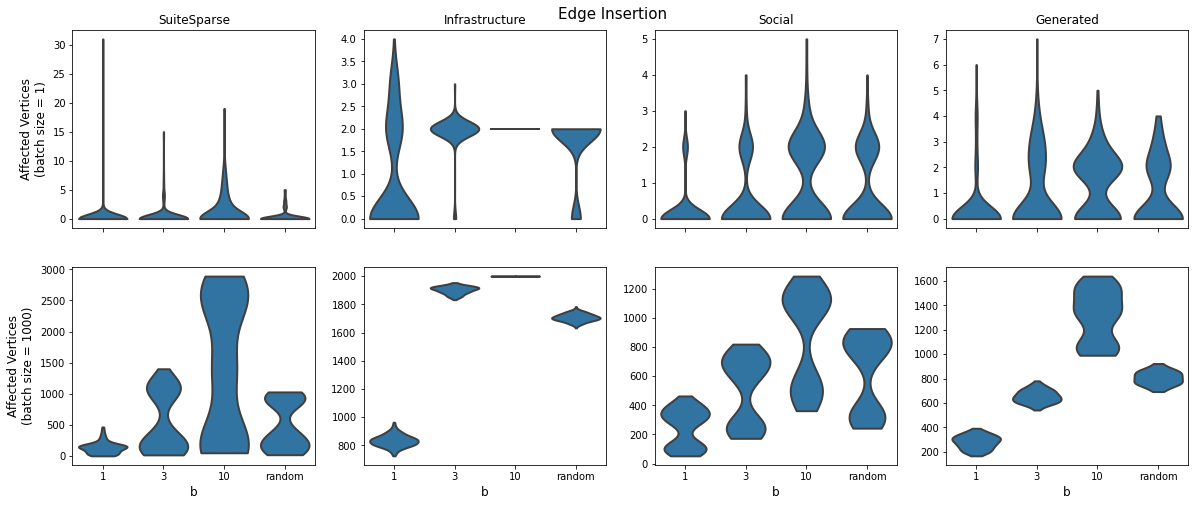

In [35]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Affected Vertices\n(batch size = 1)', 'Affected Vertices\n(batch size = 10)', 'Affected Vertices\n(batch size = 100)', 'Affected Vertices\n(batch size = 1000)']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

axs[0,0].set_ylabel(rows[0], rotation=90, fontsize=12, labelpad=5)
axs[1,0].set_ylabel(rows[3], rotation=90, fontsize=12, labelpad=5)

for ax in axs[1,:]:
    ax.set_xlabel('b', fontsize=12)
    
fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
df_affected.groupby('batch_size').apply(plotter, op = 'insert', column = 'affected_nodes', rows=['10e0','10e3'])
plt.savefig('./plots/affected_insertion.pdf', format="pdf", bbox_inches='tight')

#### Edge Removal

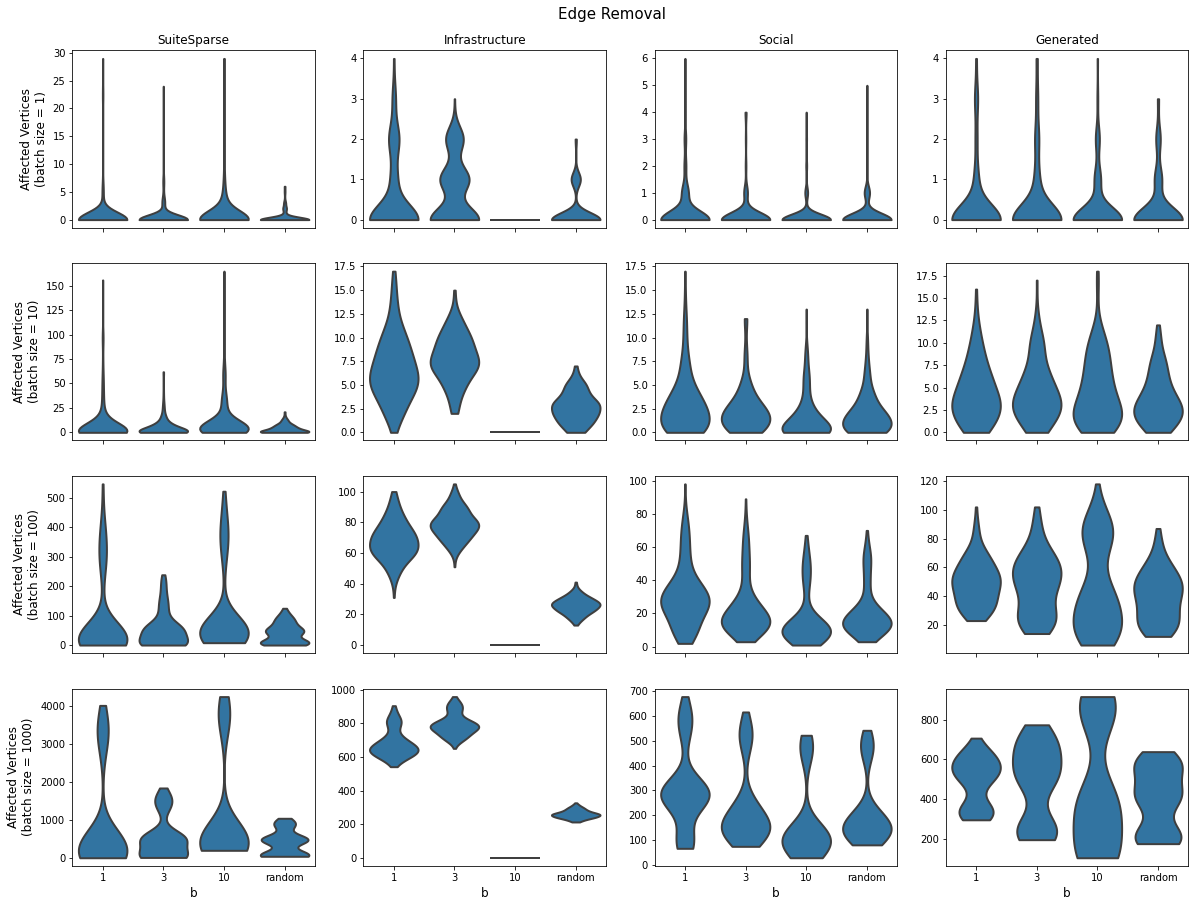

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex='all')

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

axs[0,0].set_ylabel(rows[0], rotation=90, fontsize=12, labelpad=5)
axs[1,0].set_ylabel(rows[3], rotation=90, fontsize=12, labelpad=5)

for ax in axs[1,:]:
    ax.set_xlabel('b', fontsize=12)
    
fig.suptitle("Edge Removal", y=0.92, fontsize=15)
    
df_affected.groupby('batch_size').apply(plotter, op = 'remove', column = 'affected_nodes', rows=['10e0','10e3'])
plt.savefig('./plots/affected_insertion.pdf', format="pdf", bbox_inches='tight')

### Speedup

#### Edge Insertion

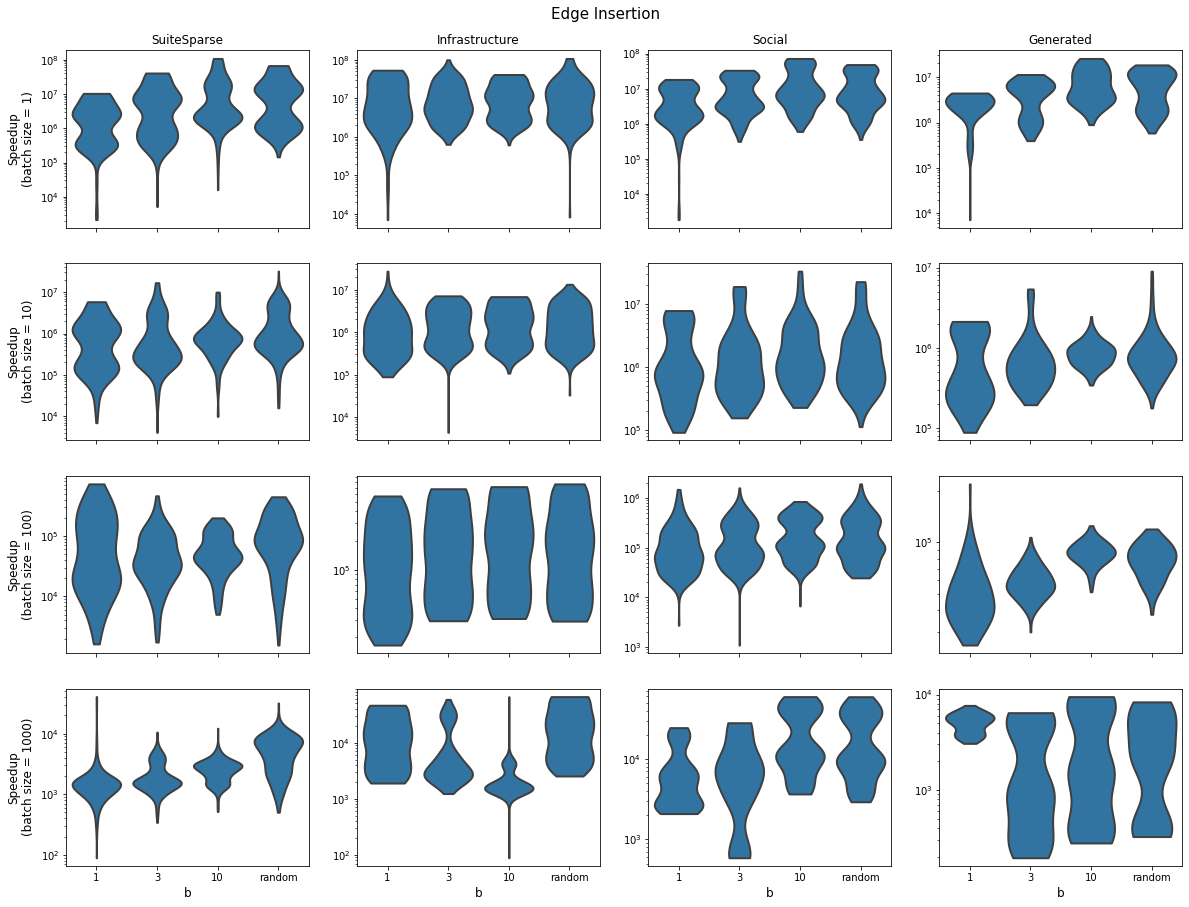

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

cols = ['{}'.format(col) for col in ['SuiteSparse', 'Infrastructure', 'Social', 'Generated']]
rows = ['{}'.format(col) for col in ['Speedup\n(batch size = 1)', 'Speedup\n(batch size = 10)', 'Speedup\n(batch size = 100)', 'Speedup\n(batch size = 1000)']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)

for iy, ix in np.ndindex(axs.shape):
    axs[iy, ix].set_yscale('log')

fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
df_speedup.groupby('batch_size').apply(plotter, op = 'insert', column = 'speedup')
plt.savefig('./plots/speedup_insertion.pdf', format="pdf", bbox_inches='tight')

#### Edge Removal

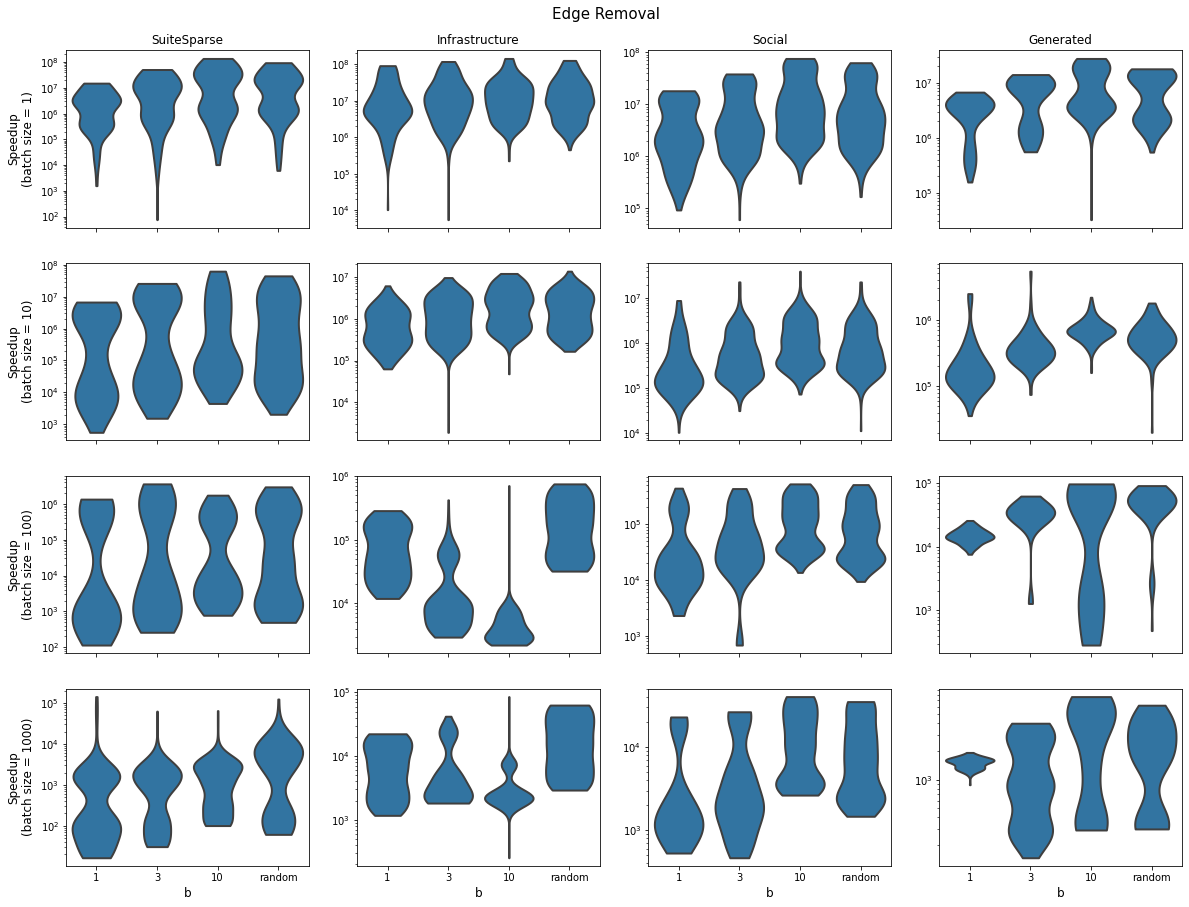

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(20, 15), sharex='all')

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=5)

for ax in axs[3,:]:
    ax.set_xlabel('b', fontsize=12)

for iy, ix in np.ndindex(axs.shape):
    axs[iy, ix].set_yscale('log')
    
fig.suptitle("Edge Removal", y=0.92, fontsize=15)
    
df_speedup.groupby('batch_size').apply(plotter, op = 'remove', column = 'speedup')
plt.savefig('./plots/speedup_removal.pdf', format="pdf", bbox_inches='tight')

## Parallel

In [13]:
# Exclude runs with wrong results, marked by "We are screwed" string in output file
def check_result(run):
    oFile = run.open_output_file()
    if 'We are screwed' in oFile.read():
        return False
    return True
    
def parse_par(run):
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name

    output_dict = dict()
    # Read output
    oFile = run.open_output_file()
    par_runtime = 0.0
    
    for line in oFile:
        if line.startswith('Matching Time:'):
            par_runtime = float(line.split(':')[1].strip())
            
    inst = run.instance.shortname.split('-mtx')[0]
    group = list(run.instance.instsets)[0].split('_mtx')[0]
    
    return {
        'experiment': run.experiment.name,
        'instance': inst,
        'group': group,
        'b': var_dict['b_value'].split('3_b_val=')[1],
        'par_runtime': par_runtime
    }

In [14]:
results_par = []
for successful_run in cfg.collect_successful_results():
    if 'static' in successful_run.experiment.name and check_result(successful_run):
        results_par.append(parse_par(successful_run))

In [15]:
df_par = pd.DataFrame(results_par)
df_par = df_par.sort_values(by=['group'])

groupSeries = np.sort(pd.unique(df_par.group)).astype(str)
df_par['group'] = pd.Categorical(df_par['group'], categories=groupSeries, ordered=True)

In [16]:
if not 'par_speedup' in df_seq.columns:
    init_list = [[]] * df_seq.shape[0]
    df_seq.insert(df_seq.shape[1], 'par_speedup',init_list)

for i, row in df_seq.iterrows():
    inst = row['instance']
    b = row['b']
    dQuery = df_par.query('instance == @inst and b == @b')
    if len(dQuery.index) > 0:
        speedup_values = [0.0] * 50
        par_runtime = dQuery['par_runtime'].item()
        for idx, val in enumerate(row['dyn_runtime']):
            speedup_values[idx] = par_runtime / val
        df_seq['par_speedup'][i] = speedup_values

/tmp/ipykernel_3233995/904313626.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq['par_speedup'][i] = speedup_values


In [17]:
df_par_speedup = df_seq.loc[(df_seq['b'] != 'random') & (df_seq['batch_size'] != '10e1') & (df_seq['batch_size'] != '10e2')].groupby(['group','b','batch_size']).agg({'par_speedup' : 'sum'})
df_par_speedup.reset_index(inplace=True)

for i, row in df_par_speedup.iterrows():
    local_b = [row['b']] * len(row['par_speedup'])
    df_par_speedup['b'][i] = local_b


/tmp/ipykernel_3233995/373699698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_par_speedup['b'][i] = local_b


### Parallel speedup plot

In [18]:
# Plotting function
def par_plotter(localDf, column):
    if (localDf['batch_size'] == '10e0').all():
        y = 0
    if (localDf['batch_size'] == '10e3').all():
        y = 1
    for i, val in enumerate(["real_sparse", "real_infrastructure", "real_social", "random"]):
        localQuery = localDf.query('group == @val')
        sns.violinplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), bw_adjust=1.2, inner=None, linewidth=2, cut=0, density_norm="count", ax=axs[y, i], order=[ '1', '2', '3', '10'])

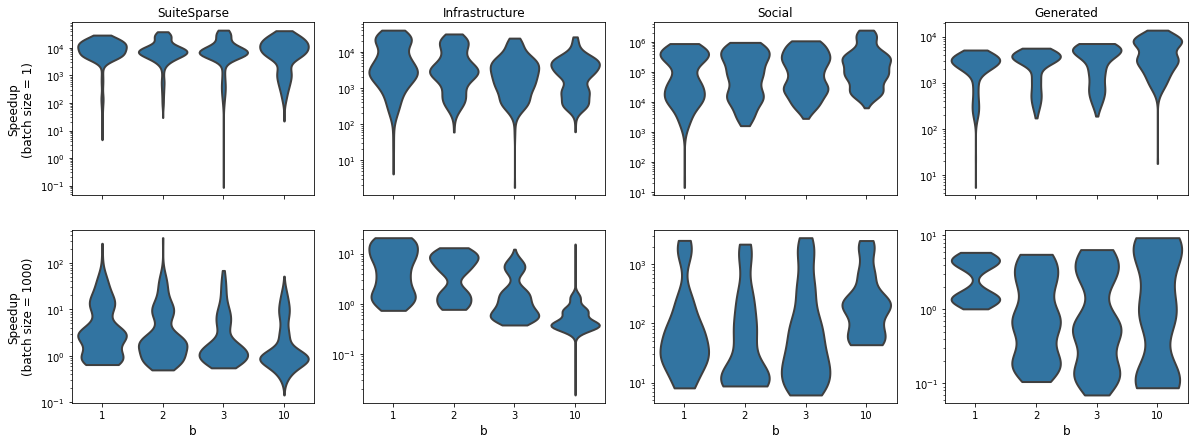

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(20, 7), sharex='all')

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

axs[0,0].set_ylabel(rows[0], rotation=90, fontsize=12, labelpad=5)
axs[1,0].set_ylabel(rows[3], rotation=90, fontsize=12, labelpad=5)

for iy, ix in np.ndindex(axs.shape):
    axs[iy, ix].set_yscale('log')

for ax in axs[1,:]:
    ax.set_xlabel('b', fontsize=12)
    
df_par_speedup.groupby('batch_size').apply(par_plotter, column = 'par_speedup')
plt.savefig('./plots/speedup_parallel.pdf', format="pdf", bbox_inches='tight')